In [1]:
!pip install tqdm

from tqdm import tqdm
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import seaborn as sns
from random import randint
from PIL import Image
import tensorflow as tf

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [0]:
tf.set_random_seed(10)
np.random.seed(10)

In [3]:

df = pd.read_csv('https://github.com/harveenchadha/dump-nn-tf/raw/master/Section2/NN_Predict_Fraud/train.csv')
df.dropna(inplace=True)
iris = tf.contrib.learn.datasets.load_iris()

scl = StandardScaler()

Instructions for updating:
Use scikits.learn.datasets.
Instructions for updating:
Use tf.data instead.


In [0]:
def WeightsVariable(shape, num = 0):
    name = 'weights' + str(num)
    return tf.get_variable(name=name, initializer=tf.initializers.glorot_uniform(),shape=shape) #tf.nn tf.truncated_normal(shape, mean = 0.0, stddev=0.001, name=name))

def BiasVariable(shape, name = 'biases'):
    return tf.Variable(tf.constant(1.0, shape=[shape], name='biases'))

In [0]:
def network(images, channels = 1, input_shape = 4, output_shape = 3):
#     num_c = [256, 128, 64, 32, 16, 8, 4]
    num_i = 0
    with tf.name_scope('fc1'):
        weights = WeightsVariable([input_shape, num_c[num_i]], num = num_i)
        biases = BiasVariable(num_c[num_i])
        fc1 = tf.nn.relu(tf.matmul(images, weights) + biases)
    num_i += 1
    for i in range(len(num_c)-2):
        name = 'fc' + str(i+2)
        with tf.name_scope(name):
            weights = WeightsVariable([num_c[num_i - 1], num_c[num_i]], num = num_i)
            biases = BiasVariable(num_c[num_i])
            fc1 = tf.nn.relu(tf.matmul(fc1, weights) + biases)
        num_i += 1    
#     with tf.name_scope('fc3'):
#         weights = WeightsVariable([num_c[num_i - 1], num_c[num_i]])
#         biases = BiasVariable(num_c[num_i])
#         fc1 = tf.nn.relu(tf.matmul(fc1, weights) + biases)
#     num_i += 1    
#     with tf.name_scope('fc5'):
#         weights = WeightsVariable([num_c[num_i - 1], num_c[num_i]])
#         biases = BiasVariable(num_c[num_i])
#         fc1 = tf.nn.relu(tf.matmul(fc1, weights) + biases)
#     num_i += 1    
#     with tf.name_scope('fc6'):
#         weights = WeightsVariable([num_c[num_i - 1], num_c[num_i]])
#         biases = BiasVariable(num_c[num_i])
#         fc1 = tf.nn.relu(tf.matmul(fc1, weights) + biases)   
#     num_i += 1
    with tf.name_scope('fc4'):
        weights = WeightsVariable([num_c[num_i - 1], output_shape], num = num_i)
        biases = BiasVariable(output_shape)
        fc2 = tf.matmul(fc1, weights) + biases
    return fc2

In [0]:
def loss_metrics(logits, labels, output_shape=1):
    logits = logits
    if output_shape == 1:
      cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(labels = labels, 
                                                                   logits = logits, 
                                                                   name = 'softmax')
      
    else:
      cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels = labels, 
                                                                   logits = logits, 
                                                                   name = 'softmax')
    return tf.reduce_mean(cross_entropy, name = 'softmax_mean')

In [0]:
#returns the optimizer by taking the loss
def training(loss):
    global_step = tf.Variable(0, name = 'global_step', trainable = False)
    
    learning_rate = tf.train.exponential_decay(STARTER_LR, 
                                               global_step = global_step, 
                                               decay_steps = 200, 
                                               decay_rate = 0.6, 
                                               staircase = True)
    optimizer = tf.train.AdamOptimizer(learning_rate = STARTER_LR)
    train_op = optimizer.minimize(loss)
    return train_op
    

In [0]:
def evaluation(logits, labels, output_shape = 1):
    correct = tf.nn.in_top_k(logits, labels, k = 1)
    return tf.reduce_sum(tf.cast(correct, tf.int32))#, accuracy1, accuracy2
  
def acc(logits, labels, output_shape = 1):
  
    if(output_shape == 1):
        correct_prediction = tf.equal(tf.cast(tf.greater_equal(logits,0.5), tf.float32), tf.cast(labels, tf.float32))
        
    else:
        correct_prediction = tf.equal(tf.argmax(logits, 1),  tf.cast(labels, tf.int64), name='correct_pred')
    
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name='accuracy')
    return accuracy

In [0]:
def placeholder_inputs(batch_size, input_shape=None, output_shape=1):
    image_placeholder = tf.placeholder(tf.float32, shape = (None, input_shape))
    if output_shape == 1:
      label_placeholder = tf.placeholder(tf.float32, shape = (None))
    else:
      label_placeholder = tf.placeholder(tf.int32, shape = (None))
    return image_placeholder, label_placeholder

In [0]:

loss_plot = []
acc_plot = []
train_plot = []
def run_training(x, y, input_shape=None, output_shape=1):
  
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3)
    with tf.Graph().as_default():

        images_pl, labels_pl = placeholder_inputs(BATCH_SIZE, input_shape=input_shape, output_shape = output_shape)
        logits = network(images_pl, input_shape=input_shape, output_shape=output_shape)
        
        print("Logits Calculated Successfully")
        loss = loss_metrics(logits = logits, labels = labels_pl, output_shape = output_shape)
        train_op = training(loss)
#         eval_correct = evaluation(logits, labels_pl)
        acc_val = acc(logits, labels_pl, output_shape = output_shape)
        summary = tf.summary.merge_all()
        
        init = tf.global_variables_initializer()
        
        gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.9) #OPTIONAL
        sess = tf.Session(config=tf.ConfigProto(gpu_options = gpu_options))
        
        saver = tf.train.Saver()
        sess.run(init)
        for steps in range(MAX_STEPS):
            loss_avg = []
            for i in tqdm(np.arange(0, len(x_train), BATCH_SIZE)):
                images_feed = x_train[i*BATCH_SIZE:i*(BATCH_SIZE+1)]
                labels_feed = y_train[i*BATCH_SIZE:i*(BATCH_SIZE+1)]

                feed_dict = { images_pl: images_feed, labels_pl: labels_feed }

                _ = sess.run([train_op], feed_dict = feed_dict)
                

            images_feed = x_test
            labels_feed = y_test

            feed_dict = {
                images_pl: images_feed,
                labels_pl: labels_feed
                        }
            loss_  = sess.run([loss], feed_dict = feed_dict)
            accuracy_val  = sess.run([acc_val], feed_dict = feed_dict)
            images_feed = x_train
            labels_feed = y_train

            feed_dict = {
                images_pl: images_feed,
                labels_pl: labels_feed
                        }
            train_loss  = sess.run([loss], feed_dict = feed_dict)
            
            loss_plot.append(loss_)
            train_plot.append(train_loss)
            acc_plot.append(accuracy_val)
            print('Loss %d: Training loss = %.5f  Validation loss = %.5f\t Validation Acc = %.5f' % (steps+1, train_loss[0], loss_[0], accuracy_val[0]))     
          
        return sess, images_pl, labels_pl, acc_val, logits

In [80]:

x = iris[0]
y = iris[1]

x = df.iloc[:, :30]
y = df.iloc[:, -1:]


x = scl.fit_transform(x)

STARTER_LR = 2e-5
BATCH_SIZE = 4
MAX_STEPS = 15
num_c = [512, 256, 128, 64, 32]

loss_plot = []
acc_plot = []
train_plot = []
sess, images_pl, labels_pl, eval_correct, logits = run_training(np.asarray(x, dtype = np.float32), np.asarray(y, dtype = np.float32), 
                      
                                                                input_shape=x.shape[1], output_shape=1)

Logits Calculated Successfully


 16%|█▋        | 26/158 [00:00<00:00, 251.36it/s]

Loss 1: Training loss = 0.52121  Validation loss = 0.52174	 Validation Acc = 0.66667


 16%|█▋        | 26/158 [00:00<00:00, 254.41it/s]

Loss 2: Training loss = 0.39352  Validation loss = 0.39524	 Validation Acc = 0.76667


 16%|█▋        | 26/158 [00:00<00:00, 246.70it/s]

Loss 3: Training loss = 0.36022  Validation loss = 0.36494	 Validation Acc = 0.79259


 17%|█▋        | 27/158 [00:00<00:00, 256.63it/s]

Loss 4: Training loss = 0.33513  Validation loss = 0.34461	 Validation Acc = 0.81111


 16%|█▋        | 26/158 [00:00<00:00, 247.27it/s]

Loss 5: Training loss = 0.32554  Validation loss = 0.33869	 Validation Acc = 0.84074


 16%|█▋        | 26/158 [00:00<00:00, 251.90it/s]

Loss 6: Training loss = 0.30161  Validation loss = 0.31880	 Validation Acc = 0.85556


 16%|█▋        | 26/158 [00:00<00:00, 256.18it/s]

Loss 7: Training loss = 0.28252  Validation loss = 0.30321	 Validation Acc = 0.86667


 16%|█▋        | 26/158 [00:00<00:00, 248.03it/s]

Loss 8: Training loss = 0.26871  Validation loss = 0.29230	 Validation Acc = 0.87778


 16%|█▋        | 26/158 [00:00<00:00, 248.99it/s]

Loss 9: Training loss = 0.25263  Validation loss = 0.27938	 Validation Acc = 0.87778


 16%|█▋        | 26/158 [00:00<00:00, 255.37it/s]

Loss 10: Training loss = 0.25056  Validation loss = 0.27905	 Validation Acc = 0.87778


 17%|█▋        | 27/158 [00:00<00:00, 264.86it/s]

Loss 11: Training loss = 0.23618  Validation loss = 0.26760	 Validation Acc = 0.89259


 16%|█▋        | 26/158 [00:00<00:00, 252.05it/s]

Loss 12: Training loss = 0.23684  Validation loss = 0.26898	 Validation Acc = 0.88889


 16%|█▋        | 26/158 [00:00<00:00, 256.01it/s]

Loss 13: Training loss = 0.22821  Validation loss = 0.26214	 Validation Acc = 0.89630


 17%|█▋        | 27/158 [00:00<00:00, 250.96it/s]

Loss 14: Training loss = 0.22326  Validation loss = 0.25870	 Validation Acc = 0.89630


100%|██████████| 158/158 [00:00<00:00, 443.08it/s]

Loss 15: Training loss = 0.22400  Validation loss = 0.26054	 Validation Acc = 0.89630


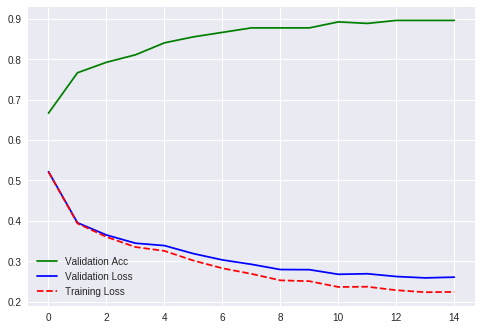

In [81]:
sns.set_style("darkgrid")
plt.plot(acc_plot,'g-',label="Validation Acc")
plt.plot(loss_plot, 'b-', label="Validation Loss")
plt.plot(train_plot, "r--", label='Training Loss')
plt.legend(loc='best')

In [82]:
images_feed, labels_feed = MNIST_DATASETS.validation.images, MNIST_DATASETS.validation.labels

feed_dict = {
    images_pl: np.reshape(images_feed, (-1, 28, 28, 1))
            }
with sess.as_default():
  accuracy  = sess.run([logits], feed_dict = feed_dict)
  
  preds = np.argmax(accuracy[0], 1)
  print(preds)

NameError: ignored

In [83]:
from sklearn.metrics import classification_report
print(classification_report(labels_feed, preds))

NameError: ignored

In [0]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(labels_feed, preds))

[[473   0   0   0   0   2   2   0   0   2]
 [  0 553   2   2   1   0   1   2   2   0]
 [  1  10 454   5   1   1   0   7   8   1]
 [  0   1   2 475   0   7   0   5   2   1]
 [  0   1   0   0 526   0   4   1   0   3]
 [  0   1   1   0   1 427   0   0   3   1]
 [  3   2   0   0   1   1 493   0   1   0]
 [  0   2   2   1   3   0   0 536   0   6]
 [  0   2   0   1   0   3   1   2 449   4]
 [  2   1   0   2   5   2   0   7   2 474]]


In [0]:
# graph = tf.GraphDef()
# graph.ParseFromString(tf_model.SerializeToString())

# with tf.Graph().as_default() as graph:
#         # The name var will prefix every op/nodes in your graph
#         # Since we load everything in a new graph, this is not needed
#     tf.import_graph_def(graph, name="prefix")
    
    